In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Generator

In [14]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        # z_dim : noise
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=z_dim,
                out_channels=image_size*8,
                kernel_size=4,
                stride=1
            ),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True)
        )

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=image_size*8,
                out_channels=image_size*4,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True)
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=image_size*4,
                out_channels=image_size*2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True)
        )

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=image_size*2,
                out_channels=image_size,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True)
        )

        self.last = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=image_size,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.Tanh()
        )

    def forward(self, z):
        out = []
        out.append(self.layer1(z))
        out.append(self.layer2(out[0]))
        out.append(self.layer3(out[1]))
        out.append(self.layer4(out[2]))
        out.append(self.last(out[3]))

        return out[4]

torch.Size([1, 1, 64, 64])


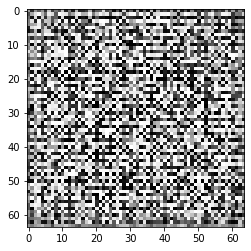

In [77]:
# Check
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1,20)

input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [18]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=image_size,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(
                negative_slope=0.1,
                inplace=True
            )
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=image_size,
                out_channels=image_size*2,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(
                negative_slope=0.1,
                inplace=True
            )
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=image_size*2,
                out_channels=image_size*4,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(
                negative_slope=0.1,
                inplace=True
            )
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(
                in_channels=image_size*4,
                out_channels=image_size*8,
                kernel_size=4,
                stride=2,
                padding=1
            ),
            nn.LeakyReLU(
                negative_slope=0.1,
                inplace=True
            )
        )

        self.last = nn.Conv2d(
            in_channels=image_size*8,
            out_channels=1,
            kernel_size=4,
            stride=1
        )

    def forward(self, x):
        out = []
        out.append(self.layer1(x))
        out.append(self.layer2(out[0]))
        out.append(self.layer3(out[1]))
        out.append(self.layer4(out[2]))
        
        feature = out[3]
        feature = feature.view(feature.size()[0], -1)

        out.append(self.last(out[3]))

        return out[4], feature

In [20]:
# Check
D = Discriminator(z_dim=20, image_size=64)

input_z = torch.randn(1,20)
input_z = input_z.view(input_z.size(0), input_z.size(1),1,1)
fake_images = G(input_z)

d_out = D(fake_images)

print(nn.Sigmoid()(d_out[0]))
print(d_out[1].shape)

tensor([[[[0.4956]]]], grad_fn=<SigmoidBackward>)
torch.Size([1, 8192])


# DataLoader

In [21]:
def make_datapath_list():

    train_img_list = list()

    for img_idx in range(200):
        img_path = f"./data/img_78/img_7_{img_idx}.jpg" 
        train_img_list.append(img_path)

        img_path = f"./data/img_78/img_8_{img_idx}.jpg" 
        train_img_list.append(img_path)

    return train_img_list

In [22]:
class ImageTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)

In [23]:
class GAN_Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)

        img_transformed = self.transform(img)
        
        return img_transformed

In [24]:
# Check

train_img_list = make_datapath_list()

mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list,
    transform=ImageTransform(mean,std)
)

batch_size = 64

train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)
print(imges.size())

torch.Size([64, 1, 64, 64])


In [28]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2d, ConvTranspose2d
        nn.init.normal_(m.weight.data, 0.0, 0.03)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

print(G.apply(weights_init))
print(D.apply(weights_init))

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(20, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride

In [39]:
def train_model(G, D, dataloader, num_epochs):
    # Setting device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Device:{device}")

    # Setting optimizer
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1,beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1,beta2])

    # Define loss function
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # Hard coding params
    z_dim = 20
    mini_batch_size = 64

    # To device, Switch mode
    G.to(device)
    D.to(device)

    G.train()
    D.train()

    # Speed up if it's afford to
    torch.backends.cudnn.benchmark = True

    # Num of data, setting iter
    num_train_imgs = len(train_dataloader.dataset)
    batch_size = dataloader.batch_size

    iteration = 1
    logs = []

    losses = {"D":[],"G":[]}

    # Training loop
    for epoch in range(num_epochs):

        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        print("-----------------")
        print(f"Epoch {epoch}/{num_epochs}")
        print("-----------------")

        # Train per batchces
        for imges in dataloader:

            # batch_size==1 -> BatchNorm error
            if imges.size()[0] == 1:
                continue
            
            # 1 Train Discriminator

            # Make labels
            imges = imges.to(device)
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # Discrimnate real images
            d_out_real, _ = D(imges)

            # Make fake images and dicriminate it
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # Calculate loss
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # Backpropagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()


            # 2 Train Generator

            # Make fake images and dicriminate it
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images)

            # Calculate loss
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # Backpropagation
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()


            # 3 Recording
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        t_epoch_finish = time.time()
        print("-----------------")
        print(f"epoch {epoch} ||Epoch D Loss{epoch_d_loss/batch_size:.4f} ||Epoch G Loss{epoch_g_loss/batch_size:.4f}")
        print(f"timer: {t_epoch_finish-t_epoch_start:.4f} sec.")
        t_epoch_start = time.time()
        losses["D"].append(epoch_d_loss/batch_size)
        losses["G"].append(epoch_g_loss/batch_size)

    print(f"Iteration num:{iteration}")

    return G, D, losses


In [40]:
num_epochs = 300
G_update, D_update, losses = train_model(G,D, dataloader=train_dataloader, num_epochs=num_epochs)

----------
-----------------
epoch 157 ||Epoch D Loss0.0259 ||Epoch G Loss0.4376
timer: 12.8072 sec.
-----------------
Epoch 158/300
-----------------
-----------------
epoch 158 ||Epoch D Loss0.0145 ||Epoch G Loss0.5512
timer: 12.9155 sec.
-----------------
Epoch 159/300
-----------------
-----------------
epoch 159 ||Epoch D Loss0.0477 ||Epoch G Loss0.3582
timer: 12.8396 sec.
-----------------
Epoch 160/300
-----------------
-----------------
epoch 160 ||Epoch D Loss0.0162 ||Epoch G Loss0.4932
timer: 12.7358 sec.
-----------------
Epoch 161/300
-----------------
-----------------
epoch 161 ||Epoch D Loss0.0759 ||Epoch G Loss0.4530
timer: 12.7753 sec.
-----------------
Epoch 162/300
-----------------
-----------------
epoch 162 ||Epoch D Loss0.0184 ||Epoch G Loss0.4220
timer: 12.7562 sec.
-----------------
Epoch 163/300
-----------------
-----------------
epoch 163 ||Epoch D Loss0.0108 ||Epoch G Loss0.4785
timer: 12.6413 sec.
-----------------
Epoch 164/300
-----------------
---------

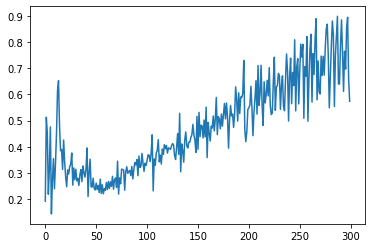

In [67]:
plt.plot(range(0,300),losses["G"])

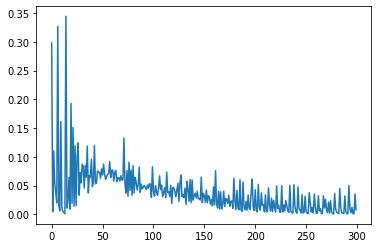

In [68]:
plt.plot(range(0,300),losses["D"])

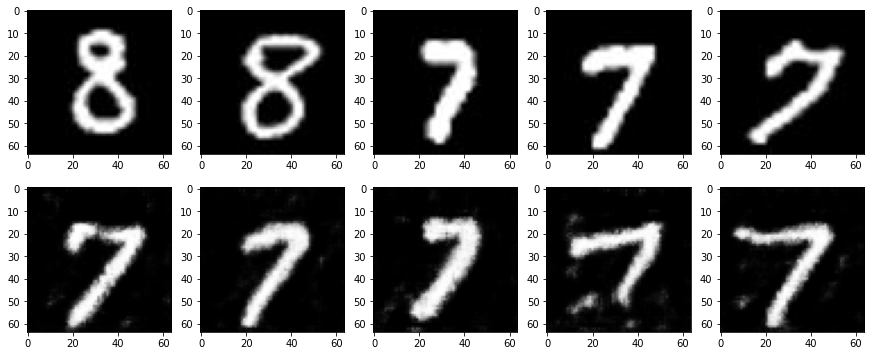

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0),fixed_z.size(1), 1, 1)
fake_images = G_update(fixed_z.to(device))

batch_iterator = iter(train_dataloader)
imges = next(batch_iterator)

fig = plt.figure(figsize=(15,6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(),'gray')

# Anomaly-GAN

In [69]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):

    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    _, x_feature = D(x)
    _, G_feature = D(fake_img)

    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

In [70]:
def make_test_datapath_list():

    train_img_list = list()

    for img_idx in range(5):
        img_path = f"./data/test/img_7_{img_idx}.jpg"
        train_img_list.append(img_path)
        
        img_path = f"./data/test/img_8_{img_idx}.jpg"
        train_img_list.append(img_path)

        img_path = f"./data/test/img_2_{img_idx}.jpg"
        train_img_list.append(img_path)

    return train_img_list

test_img_list = make_test_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list,
    transform=ImageTransform(mean, std)
)

batch_size = 5
test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

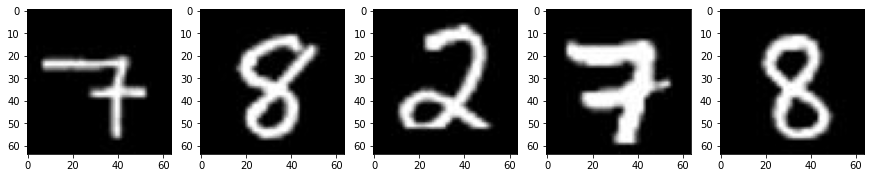

In [72]:
batch_iterator = iter(test_dataloader)
imges = next(batch_iterator)

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2,5,i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

In [83]:
x = imges[0:5]
x = x.to(device)

z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

z.requires_grad = True
z_optimizer = torch.optim.Adam([z], lr=1e-3)

x.shape
fake_img = G_update(z)
fake_img.shape
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print(f"epoch {epoch} || loss_total:{loss.item():.0f}")

epoch 0 || loss_total:6555
epoch 1000 || loss_total:4828
epoch 2000 || loss_total:4011
epoch 3000 || loss_total:3737
epoch 4000 || loss_total:3628
epoch 5000 || loss_total:3566


total loss:[645. 660. 962. 620. 678.]


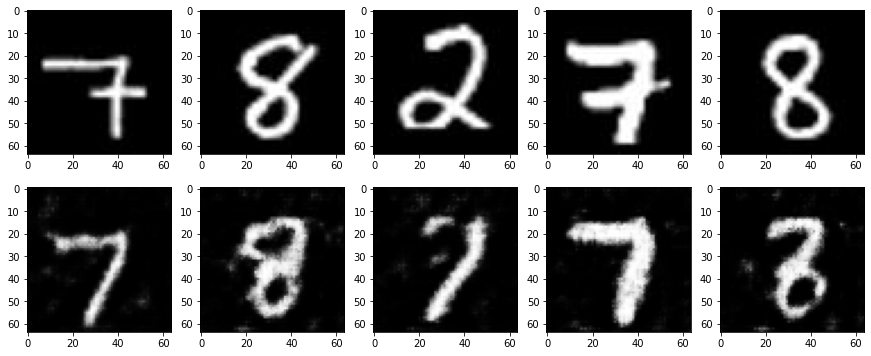

In [87]:
G_update.eval()
fake_img = G_update(z)

loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1
)

loss_each = loss_each.cpu().detach().numpy()
print(f"total loss:{np.round(loss_each, 0)}")

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2,5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    plt.subplot(2,5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')